In [1]:
import os
import sys
import wandb
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from sklearn.model_selection import train_test_split
# Use these commands in the same cell to autoreload local library source code
# https://stackoverflow.com/questions/45807760/change-source-code-and-update-jupyter-notebook-but-retain-variables
%load_ext autoreload
%autoreload 2

In [ ]:
torch.cuda.is_available()

True

In [26]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: dt-young112 (sccn). Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="hbn-ssl", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    #   name=f"experiment_{run}", 
      # Track hyperparameters and run metadata
      config={
        "n_subjects": 500,
        "window": 5,
        'mask_prob':0.3,
        'num_epochs': 10,
        'batch_size': 30,
        'epochs': 10
      })
config = wandb.config

In [4]:
def get_subjects(basedir):
    files = np.array([i for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    subjects = np.array([i.split('_')[0] for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    return subjects, files

subjects, files = get_subjects("/mnt/nemar/child-mind-rest")
subj_train, subj_test, files_train, files_test = train_test_split(subjects, files, test_size=0.1, random_state=1)
subj_train, subj_val, files_train, files_val = train_test_split(subj_train, files_train, test_size=0.22, random_state=1) # 0.22 x 0.9 = 0.2

In [2]:
dataset = HBNRestBIDSDataset(
        data_dir = "/mnt/nemar/openneuro/ds004186",
        x_params = {
            'sfreq': 128,
            'window': 5,
        },
    )

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Data shape: C, T: 128, 640
Creating RawArray with float64 data, n_channels=128, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 5.000 (s)


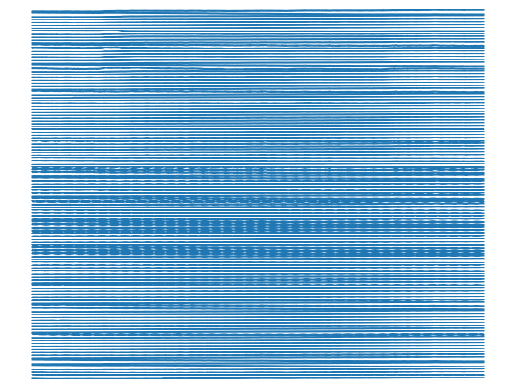

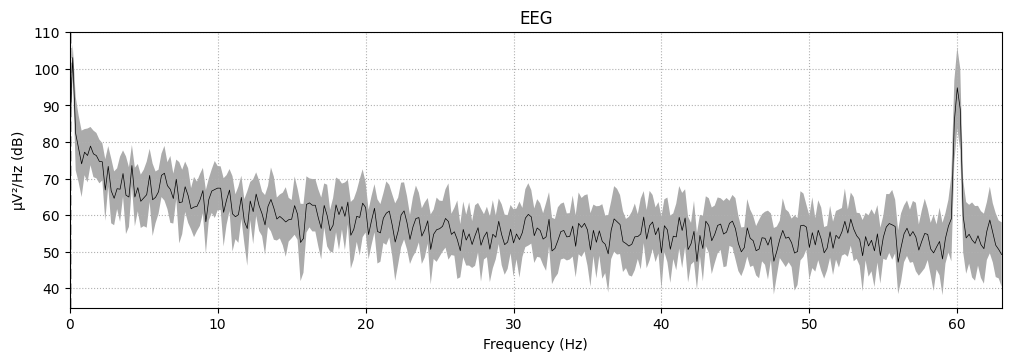

In [9]:
import time
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Wav2VecBrainModel()
model.to(device=device)
model.train()
for e in range(1):
    start_time = time.time()
    for t, samples in enumerate(dataloader):
        # eeg_utils.plot_raw_eeg(samples[0].numpy(), 128)
        # break
        shuffling_indices = list(range(samples.shape[0]))
        np.random.shuffle(shuffling_indices)
        # subj = np.array(subj)[shuffling_indices]
        shuffling_indices = torch.tensor(shuffling_indices)
        samples = torch.index_select(samples, 0, shuffling_indices)

        samples = samples.to(device=device, dtype=torch.float32)
        print(model(samples).shape)
        print('Iteration %d took %s second(s)' % (t, time.time() - start_time))
        start_time = time.time()

In [10]:
task = MaskedContrastiveLearningTask(
    dataset=dataset,
    is_cv=False,
    is_iterable=True,
    train_params={
        'num_epochs': 100,
        'batch_size': 128,
        'print_every': 10,
        'learning_rate': 0.001,
    }
)
model = Wav2VecBrainModel()
task.train(model=model)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
dataset = HBNRestBIDSDataset(
        data_dir = "/mnt/nemar/openneuro/ds004186",
        x_params = {
            'sfreq': 128,
            'window': 20,
            'preprocessing': True
        },
    )
for bs in range(4, 12):
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        print(f"batch_size: {bs}, lr: {lr}")
        model = VGGSSL()
        trainer = Trainer(
            dataset=dataset,
            model=model,
            train_params={
                'num_epochs': 1,
                'batch_size': 4,
                'print_every': 1,
                'learning_rate': lr,
                'num_workers': 0,
            },
            task_params={
                'task': 'RelativePositioning',
                'sfreq': 128,
                'win': 0.5,
                'tau_pos': 10,
                'tau_neg': 10,
                'n_samples': 1,
            },
            verbose=False,
            # device='cpu'
        )
        trainer.train()

batch_size: 4, lr: 0.0001
Training parameters {'num_epochs': 1, 'batch_size': 4, 'print_every': 1, 'num_workers': 0, 'learning_rate': 0.0001}
Task parameters {'task': 'RelativePositioning', 'sfreq': 128, 'win': 0.5, 'tau_pos': 10, 'tau_neg': 10, 'n_samples': 1}


In [3]:
dataset = HBNSignalstoreDataset(
        task_params={
            "window": 2,
            "task": "EC",
        },
        data_directory='/local/directory/spectral'
    )

dataset_spectral = eeg_dash.transform(dataset, feature='spectral', window=2, directory='/local/directory/dataset/spectral')
dataset_entropy = eeg_dash.transform(dataset_spectral, feature='entropy', directory='/local/directory/dataset/entropy')

Found 17 records


In [ ]:
dataset = HBNSignalstoreDataset(
        task_params={
            "window": 2,
            "sfreq": 128,
            "task": "EC",
            "feature": "spectral"
        },
        data_directory='/local/directory/spectral'
    )

In [13]:
import time
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Wav2VecBrainModel()
model.to(device=device)
model.train()
for e in range(1):
    start_time = time.time()
    for t, (samples, subj) in enumerate(dataloader):
        shuffling_indices = list(range(samples.shape[0]))
        np.random.shuffle(shuffling_indices)
        subj = np.array(subj)[shuffling_indices]
        shuffling_indices = torch.tensor(shuffling_indices)
        samples = torch.index_select(samples, 0, shuffling_indices)

        samples = samples.to(device=device, dtype=torch.float32)
        # print(model(samples).shape, subj)
        print('Iteration %d took %s second(s)' % (t, time.time() - start_time))
        start_time = time.time()

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Found 1 records
Iteration 0 took 4.392029523849487 second(s)
Iteration 1 took 3.235060691833496 second(s)
Iteration 2 took 2.800579071044922 second(s)
Iteration 3 took 2.7360587120056152 second(s)
Iteration 4 took 2.677096366882324 second(s)
Iteration 5 took 3.2928202152252197 second(s)
Iteration 6 took 3.996832847595215 second(s)
Iteration 7 took 2.5395424365997314 second(s)
Iteration 8 took 2.7171616554260254 second(s)


KeyboardInterrupt: 